# MultiFold Hyperparameter Optimization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow as tf
from keras.models import load_model

### Custom functions
from omnifold import *
from omnifold.utilities import *

### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Plot setup
plot_setup()
plot_dir = './plots/'

2022-01-26 10:34:40.076041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-26 10:34:40.103311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-26 10:34:40.103462: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-26 10:34:40.104831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-26 10:34:40.106338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-26 10:34:40.106533: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

# Run a new unfolding (i.e. retrain the NN)

### Load files

In [3]:
mc = pd.read_hdf('./omnifold_data/zjets_powhegpythia_mc16e.h5')
data = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e.h5')
data_truth = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e_truth.h5')

with open(r'./omnifold_data/inputs.json', "r") as read_file:
    inputs = json.load(read_file)
    
for dict in inputs:
    dict['bins'] = np.asarray(dict['bins']) # cast back to numpy arrays for plotting
    
### Add in 200 GeV cuts for plotting only 
mc_pt200 = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
data_truth_pt200 = data_truth[data_truth.truth_pT_ll > 200]
data_pt200 = data[data.pT_ll > 200]
mc_filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

dummyval = -99
save_label0 = 'hpo'

### Prepare to unfold

In [4]:
K.clear_session()
print("Unfolding {} variables.".format(len(inputs)))

for dict in inputs:
    dict['bins'] = np.asarray(dict['bins']) # cast back to numpy arrays for plotting

Unfolding 24 variables.


In [5]:
mc_truth_plots = [None] * len(inputs)
mc_reco_plots = [None] * len(inputs)
data_truth_plots = [None] * len(inputs)
data_reco_plots = [None] * len(inputs)

mc_truth_hists = [None] * len(inputs)
mc_reco_hists = [None] * len(inputs)
data_truth_hists = [None] * len(inputs)
data_reco_hists = [None] * len(inputs)

# z-score standardization of data
mc_truth_z = [None] * len(inputs)
mc_reco_z = [None] * len(inputs)
data_reco_z = [None] * len(inputs)

for i in tqdm(range(len(inputs))):
    file_label = inputs[i]['file_label']
    
    mc_truth_plots[i] = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+file_label], dummyval)
    mc_reco_plots[i] = np.where(mc_pt200.pass190, mc_pt200[file_label], dummyval)
    data_truth_plots[i] = data_truth_pt200['truth_'+file_label]
    data_reco_plots[i] = data_pt200[file_label]
    
    bins = inputs[i]['bins']
    x_label = inputs[i]['plot_label']
    file_label = inputs[i]['file_label']
    os.makedirs(plot_dir+'MultiFold/'+file_label, exist_ok=True)
    save_label = plot_dir+'MultiFold/'+file_label+'/'+save_label0
    
    mc_truth_hists[i] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
    mc_reco_hists[i] = np.where(mc.pass190, mc[file_label], dummyval)
    data_truth_hists[i] = data_truth['truth_'+file_label]
    data_reco_hists[i] = data[file_label]
    
    mc_truth_z[i], mc_reco_z[i], data_reco_z[i] = standardize(
        np.array(mc_truth_hists[i]), 
        np.array(mc_reco_hists[i]), 
        np.array(data_reco_hists[i]))

#     plot_distributions(
#         sim_truth=mc_truth_plots[i],
#         sim_reco=mc_reco_plots[i],
#         sim_truth_weights_MC=mc_pt200.weight_mc,
#         sim_reco_weights_MC=mc_pt200.weight,
#         data_truth=data_truth_plots[i],
#         data_reco=data_reco_plots[i],
#         data_truth_weights_MC=data_truth_pt200.weight_mc,
#         data_reco_weights_MC=data_pt200.weight,
#         bins=bins,
#         x_label=x_label,
#         save_label=save_label
#     )

100%|██████████| 24/24 [00:02<00:00, 10.80it/s]


### Unfold!

Note that the weights returned by the MultiFold function are the *MultiFold* weights. To get the NN weights, we need to use the second object returned by the function: the model.

In [9]:
weights, model = multifold(
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data.weight,
                     dummyval=dummyval,
                     verbose=0,
                     iterations=5,
                     layer_size=200,
                     n_layers=3,
                     epochs=1000,
                     patience=10,
                     batch_size=1000,
                     livelossplot=True,
                     hpo=False,
                    )

Iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping


/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/multifold.py:17: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


Iterations::  20%|██        | 1/5 [02:29<09:59, 149.89s/it]

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


Iterations::  40%|████      | 2/5 [04:19<06:18, 126.06s/it]

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


Iterations::  60%|██████    | 3/5 [06:18<04:06, 123.08s/it]

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/multifold.py:204: RuntimeWarning: invalid value encountered in multiply
  weights_pull = weights_push * reweight(model, sim_reco)


Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


Iterations::  80%|████████  | 4/5 [08:23<02:03, 123.68s/it]

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


Iterations:: 100%|██████████| 5/5 [10:12<00:00, 122.54s/it]

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


### **Optional:** store NN model and MultiFold weights

`weights` shape: (# iterations, # unfolding steps, # events)

In [10]:
np.save("weights/multifold_weights_hpo.npy", weights)
np.save("weights/nominal_weights_hpo.npy", weights[-1,1,:])
model.save('weights/multifold_model_hpo.h5')

In [11]:
del model, weights

# Plot results from a previous unfolding:

In [12]:
save_label0 = 'hpo'

Load data:

In [13]:
mc = pd.read_hdf('./omnifold_data/zjets_powhegpythia_mc16e.h5')
data = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e.h5')
data_truth = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e_truth.h5')

with open(r'./omnifold_data/inputs.json', "r") as read_file:
    inputs = json.load(read_file)
    
for dict in inputs:
    dict['bins'] = np.asarray(dict['bins']) # cast back to numpy arrays for plotting
    
### Add in 200 GeV cuts for plotting only 
mc_pt200 = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
data_truth_pt200 = data_truth[data_truth.truth_pT_ll > 200]
data_pt200 = data[data.pT_ll > 200]
mc_filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

dummyval = -99

Load saved model & weights:

In [14]:
model = load_model('weights/multifold_model_hpo.h5', compile = False)
weights = np.load('weights/multifold_weights_hpo.npy')

Plot unfolding results:

In [ ]:
mc_truth_plots = [None] * len(inputs)
mc_reco_plots = [None] * len(inputs)
data_truth_plots = [None] * len(inputs)
data_reco_plots = [None] * len(inputs)

for i in tqdm(range(len(inputs))[:2], desc="Variables"):    
    bins = inputs[i]['bins']
    x_label = inputs[i]['plot_label']
    file_label = inputs[i]['file_label']
    os.makedirs(plot_dir+'MultiFold/'+file_label, exist_ok=True)
    save_label = plot_dir+'MultiFold/'+file_label+'/'+save_label0
    
    mc_truth_plots[i] = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+file_label], dummyval)
    mc_reco_plots[i] = np.where(mc_pt200.pass190, mc_pt200[file_label], dummyval)
    data_truth_plots[i] = data_truth_pt200['truth_'+file_label]
    data_reco_plots[i] = data_pt200[file_label]

    # Truth vs Reco
    plot_distributions(
        sim_truth=mc_truth_plots[i],
        sim_reco=mc_reco_plots[i],
        sim_truth_weights_MC=mc_pt200.weight_mc,
        sim_reco_weights_MC=mc_pt200.weight,
        data_truth=data_truth_plots[i],
        data_reco=data_reco_plots[i],
        data_truth_weights_MC=data_truth_pt200.weight_mc,
        data_reco_weights_MC=data_pt200.weight,
        bins=bins,
        x_label=x_label,
        save_label=save_label
    )
    
    # Unfolding
    plot_results(sim_truth=mc_truth_plots[i],
                 sim_reco=mc_reco_plots[i],
                 sim_truth_weights_MC=mc_pt200.weight_mc,
                 sim_reco_weights_MC=mc_pt200.weight,
                 data_truth=data_truth_plots[i],
                 data_reco=data_reco_plots[i],
                 data_truth_weights_MC=data_truth_pt200.weight_mc,
                 data_reco_weights_MC=data_pt200.weight,
                 weights=weights[:,:,mc_filter],
                 bins=bins,
                 x_label=x_label,
                 flavor_label='MultiFold',
                 save_label=save_label)

# Look at some derived variables

### tau_2 / tau_1

In [ ]:
leadtrack_tau1_index = [dict['file_label'] for dict in inputs].index('tau1_trackj1')
leadtrack_tau1 = inputs[leadtrack_tau1_index]

leadtrack_tau2_index = [dict['file_label'] for dict in inputs].index('tau2_trackj1')
leadtrack_tau2 = inputs[leadtrack_tau2_index]

In [ ]:
# Tau1 

mc_truth_plot = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+leadtrack_tau1['file_label']], dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, mc_pt200[leadtrack_tau1['file_label']], dummyval)
data_truth_plot = data_truth_pt200['truth_'+leadtrack_tau1['file_label']]
data_reco_plot = data_pt200[leadtrack_tau1['file_label']]

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=leadtrack_tau1['bins'],
    x_label=leadtrack_tau1['plot_label'],
    save_label=plot_dir + '/MultiFold/' + leadtrack_tau1['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau1['file_label']
)

# Unfolding 
plot_results(sim_truth=mc_truth_plot,
             sim_reco=mc_reco_plot,
             sim_truth_weights_MC=mc_pt200.weight_mc,
             sim_reco_weights_MC=mc_pt200.weight,
             data_truth=data_truth_plot,
             data_reco=data_reco_plot,
             data_truth_weights_MC=data_truth_pt200.weight_mc,
             data_reco_weights_MC=data_pt200.weight,
             weights=weights[:,:,mc_filter],
             flavor_label = "MultiFold",
             bins=leadtrack_tau1['bins'],
             x_label=leadtrack_tau1['plot_label'],
             save_label=plot_dir + '/MultiFold/' + leadtrack_tau1['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau1['file_label']
            )

In [ ]:
# Tau2 

mc_truth_plot = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+leadtrack_tau2['file_label']], dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, mc_pt200[leadtrack_tau2['file_label']], dummyval)
data_truth_plot = data_truth_pt200['truth_'+leadtrack_tau2['file_label']]
data_reco_plot = data_pt200[leadtrack_tau2['file_label']]

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=leadtrack_tau2['bins'],
    x_label=leadtrack_tau2['plot_label'],
    save_label=plot_dir + '/MultiFold/' + leadtrack_tau2['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau2['file_label']
)

# Unfolding 
plot_results(sim_truth=mc_truth_plot,
             sim_reco=mc_reco_plot,
             sim_truth_weights_MC=mc_pt200.weight_mc,
             sim_reco_weights_MC=mc_pt200.weight,
             data_truth=data_truth_plot,
             data_reco=data_reco_plot,
             data_truth_weights_MC=data_truth_pt200.weight_mc,
             data_reco_weights_MC=data_pt200.weight,
             weights=weights[:,:,mc_filter],
            flavor_label = "MultiFold",
             bins=leadtrack_tau2['bins'],
             x_label=leadtrack_tau2['plot_label'],
             save_label=plot_dir + '/MultiFold/' + leadtrack_tau2['file_label'] + '/' + save_label0 + '-MultiFold-' + leadtrack_tau2['file_label']
            )

In [ ]:
# tau2/tau1 

bins = np.array([0., 0.35, 0.5, 0.65, 0.7, 0.8, 1.0])
save_label=plot_dir + '/MultiFold/' + 'tau_21' + '/' + save_label0 + '-MultiFold-' + 'tau_21'
os.makedirs(plot_dir+'MultiFold/'+ 'tau_21', exist_ok=True)

mc_truth_plot = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+leadtrack_tau2['file_label']]/mc_pt200['truth_'+leadtrack_tau1['file_label']], dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, mc_pt200[leadtrack_tau2['file_label']]/mc_pt200[leadtrack_tau1['file_label']], dummyval)
data_truth_plot = data_truth_pt200['truth_'+leadtrack_tau2['file_label']]/data_truth_pt200['truth_'+leadtrack_tau1['file_label']]
data_reco_plot = data_pt200[leadtrack_tau2['file_label']]/data_pt200[leadtrack_tau1['file_label']]

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=bins,
    x_label=r"$\tau_{21}=\tau_2/\tau_1$",
    save_label=save_label
)

# Unfolding 
plot_results(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    weights=weights[:,:,mc_filter],
    bins=bins,
    x_label=r"$\tau_{21}=\tau_2/\tau_1$",
    save_label=save_label
)

### $\Delta R(ll, j_1)$

In [15]:
import vector

def ll(pt_l1, eta_l1, phi_l1, pt_l2, eta_l2, phi_l2): 
        l1 = vector.array({"pt": pt_l1, "eta": eta_l1, "phi": phi_l1, "m": np.zeros(len(pt_l1))})
        l2 = vector.array({"pt": pt_l2, "eta": eta_l2, "phi": phi_l2, "m": np.zeros(len(pt_l2))})
        return l1.add(l2)
    
def delta_r(y_ll, y_trackj1, phi_ll, phi_trackj1):
    delta_y = y_ll - y_trackj1
    delta_phi = phi_ll - phi_trackj1
    return np.sqrt(delta_y**2 + delta_phi**2)

/tmp/ipykernel_19317/370304111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_pt200['truth_phi_ll'] = ll(mc_pt200['truth_pT_l1'], mc_pt200['truth_eta_l1'], mc_pt200['truth_phi_l1'],
/tmp/ipykernel_19317/370304111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_pt200['phi_ll'] = ll(mc_pt200['pT_l1'], mc_pt200['eta_l1'], mc_pt200['phi_l1'],
/tmp/ipykernel_19317/370304111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

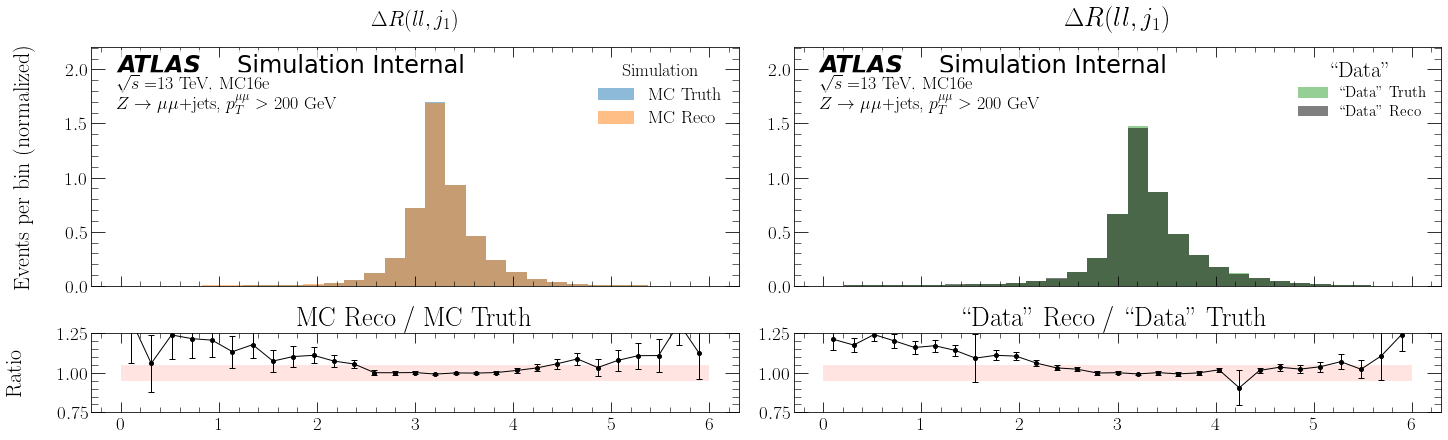

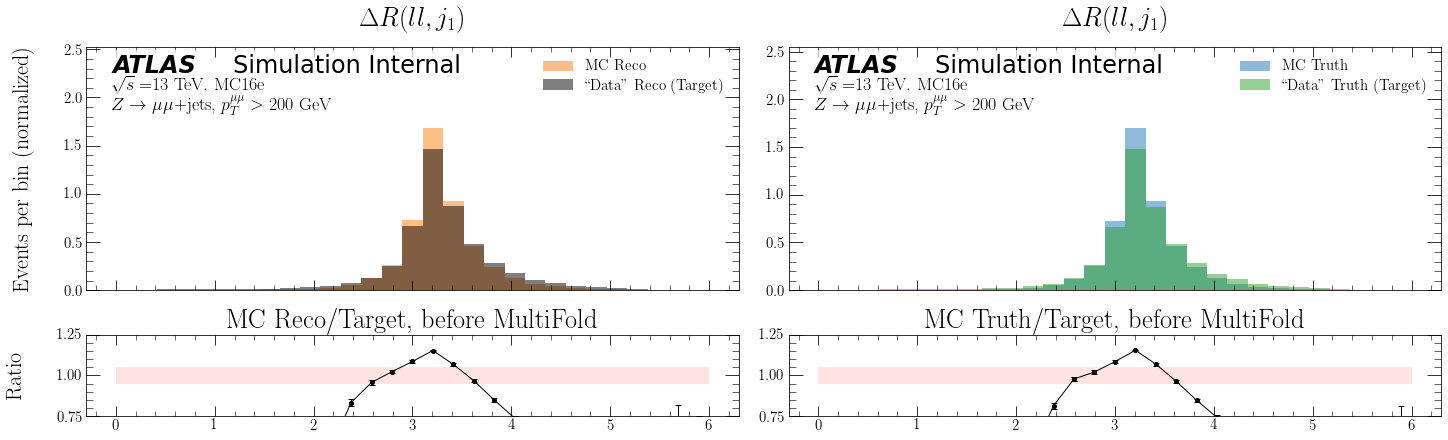

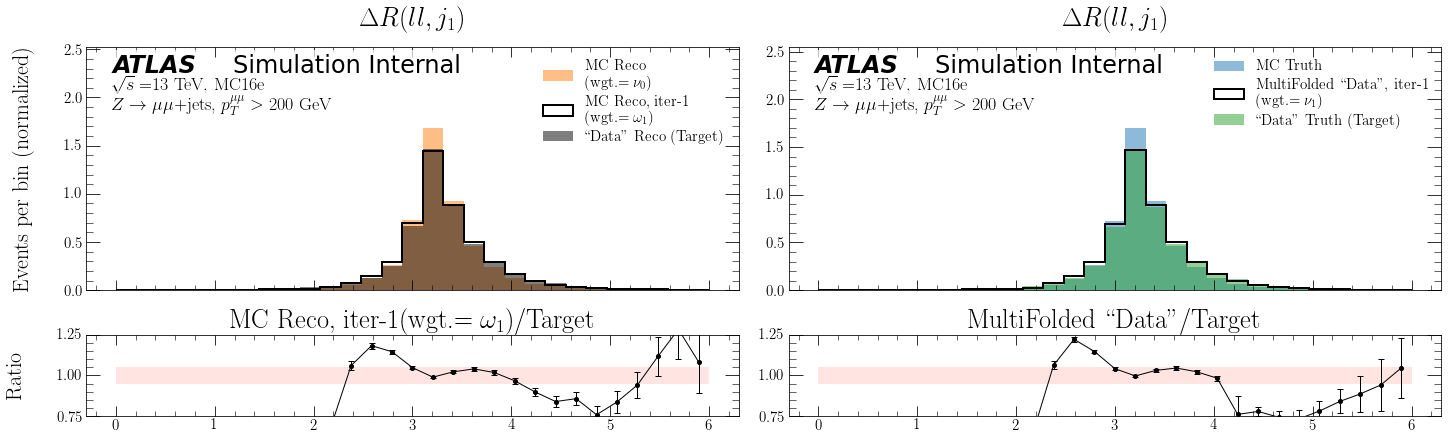

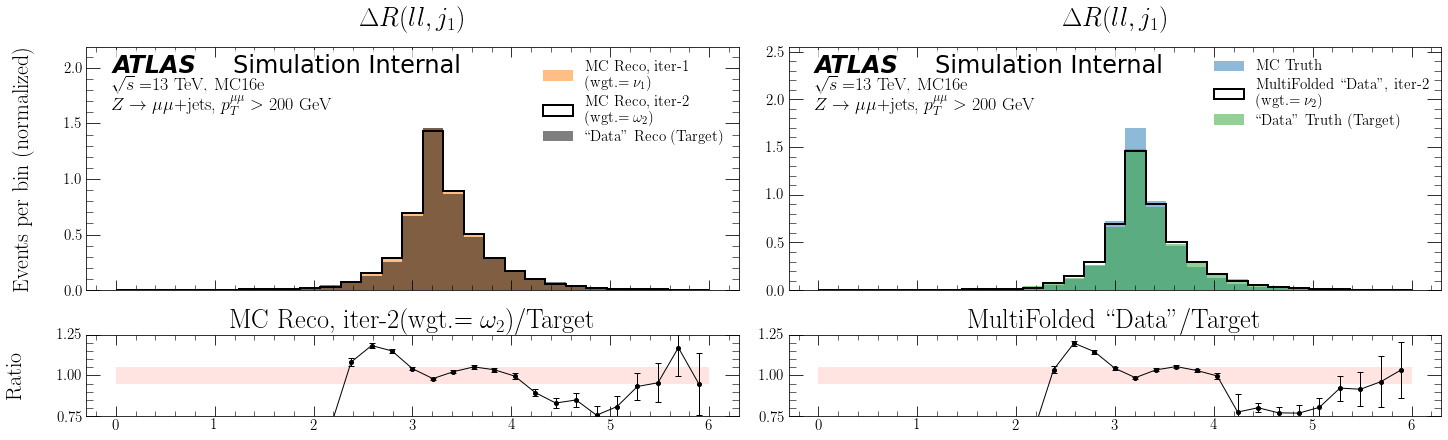

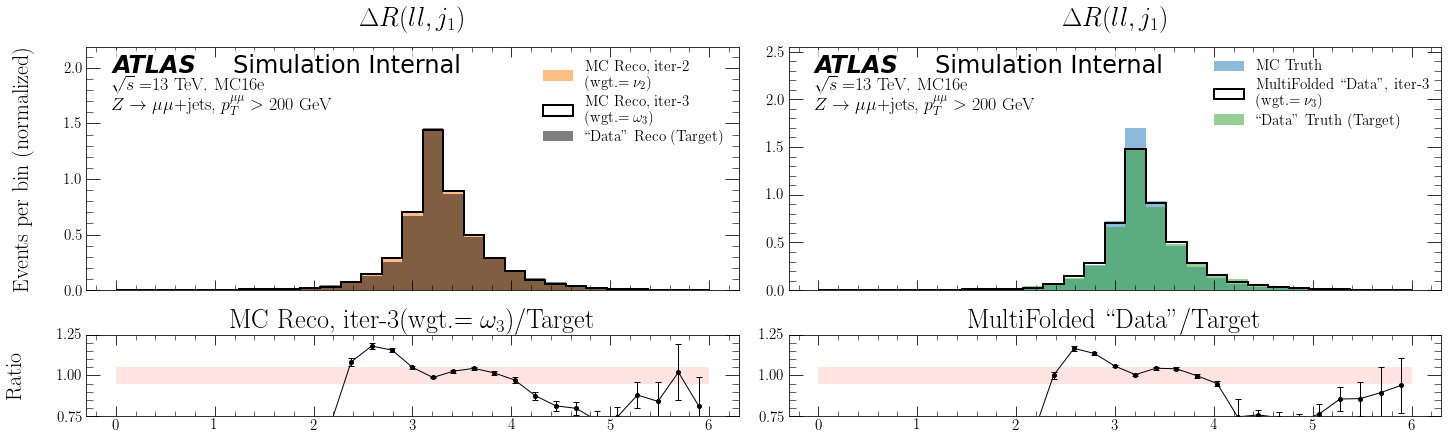

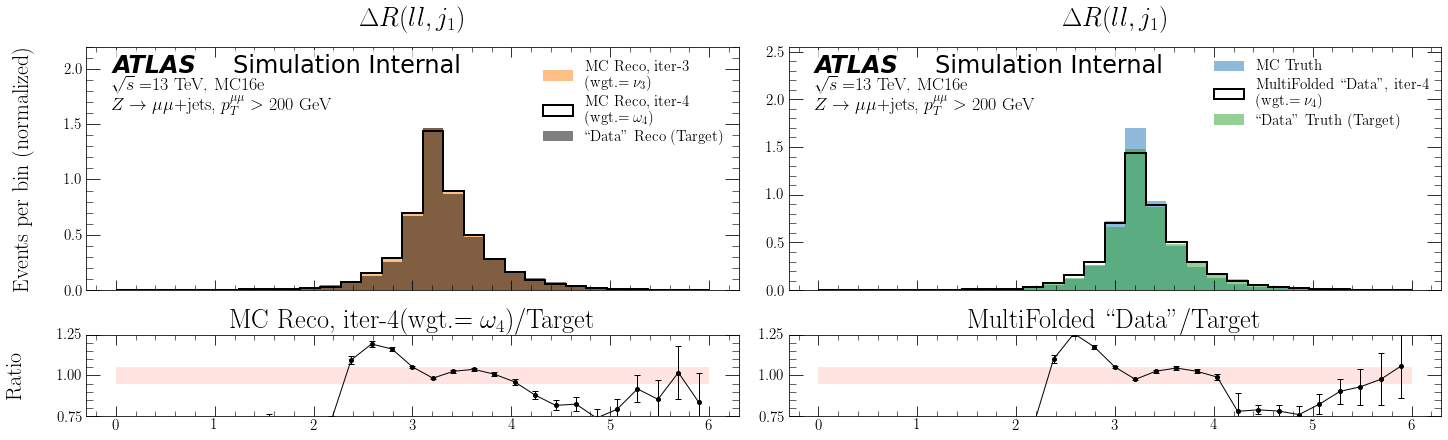

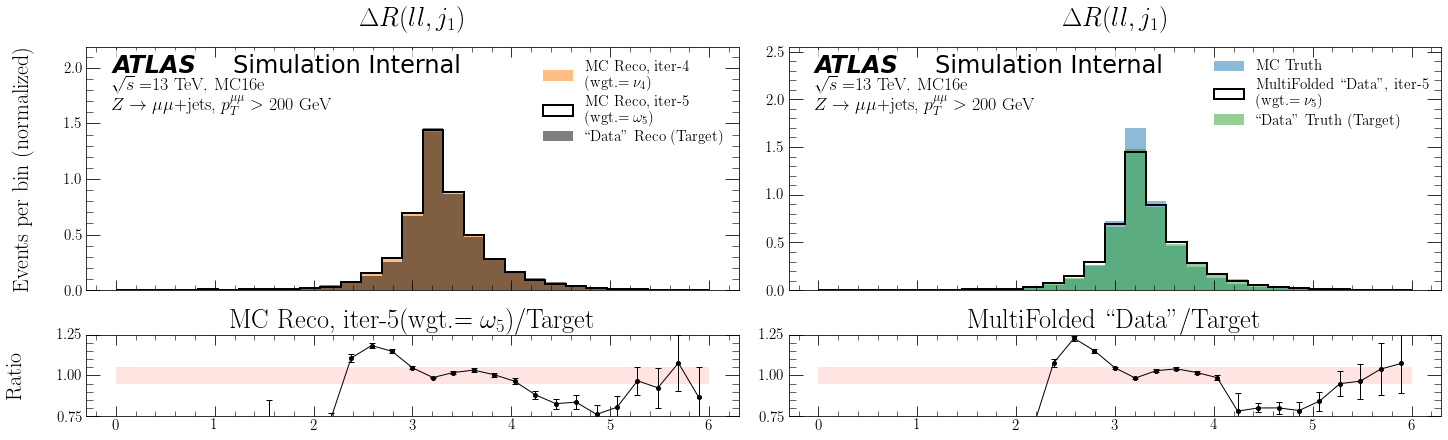

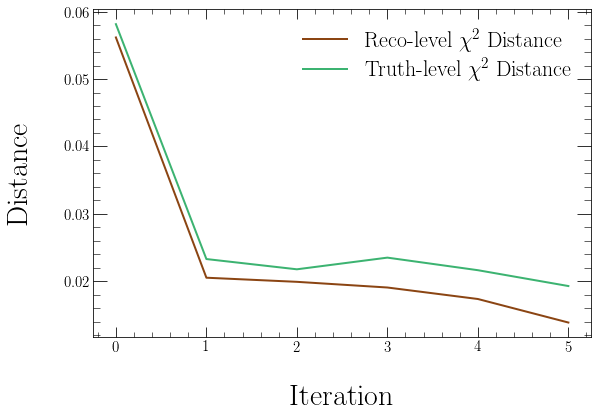

In [16]:
# DeltaR

### Define the combined dilepton phi first, before calculating DeltaR
mc_pt200['truth_phi_ll'] = ll(mc_pt200['truth_pT_l1'], mc_pt200['truth_eta_l1'], mc_pt200['truth_phi_l1'], 
                              mc_pt200['truth_pT_l2'], mc_pt200['truth_eta_l2'], mc_pt200['truth_phi_l2']).phi
mc_pt200['phi_ll'] = ll(mc_pt200['pT_l1'], mc_pt200['eta_l1'], mc_pt200['phi_l1'], 
                        mc_pt200['pT_l2'], mc_pt200['eta_l2'], mc_pt200['phi_l2']).phi
data_truth_pt200['truth_phi_ll'] = ll(data_truth_pt200['truth_pT_l1'], data_truth_pt200['truth_eta_l1'], data_truth_pt200['truth_phi_l1'], 
                                      data_truth_pt200['truth_pT_l2'], data_truth_pt200['truth_eta_l2'], data_truth_pt200['truth_phi_l2']).phi
data_pt200['phi_ll'] = ll(data_pt200['pT_l1'], data_pt200['eta_l1'], data_pt200['phi_l1'], 
                          data_pt200['pT_l2'], data_pt200['eta_l2'], data_pt200['phi_l2']).phi

mc_truth_plot = np.where(mc_pt200.truth_pass190, delta_r(mc_pt200['truth_y_ll'], mc_pt200['truth_y_trackj1'], mc_pt200['truth_phi_ll'], mc_pt200['truth_phi_trackj1']), dummyval)
mc_reco_plot = np.where(mc_pt200.pass190, delta_r(mc_pt200['y_ll'], mc_pt200['y_trackj1'], mc_pt200['phi_ll'], mc_pt200['phi_trackj1']), dummyval)
data_truth_plot = delta_r(data_truth_pt200['truth_y_ll'], data_truth_pt200['truth_y_trackj1'], data_truth_pt200['truth_phi_ll'], data_truth_pt200['truth_phi_trackj1'])
data_reco_plot = delta_r(data_pt200['y_ll'], data_pt200['y_trackj1'], data_pt200['phi_ll'], data_pt200['phi_trackj1'])

bins = np.linspace(0,6,30)
os.makedirs(plot_dir+'MultiFold/'+ 'DeltaR', exist_ok=True)

# Truth vs Reco
plot_distributions(
    sim_truth=mc_truth_plot,
    sim_reco=mc_reco_plot,
    sim_truth_weights_MC=mc_pt200.weight_mc,
    sim_reco_weights_MC=mc_pt200.weight,
    data_truth=data_truth_plot,
    data_reco=data_reco_plot,
    data_truth_weights_MC=data_truth_pt200.weight_mc,
    data_reco_weights_MC=data_pt200.weight,
    bins=bins,
    x_label=r'$\Delta R(ll,j_1)$',
    save_label=plot_dir + '/MultiFold/' + 'DeltaR' + '/' + save_label0 + '-MultiFold-' + 'DeltaR'
)

# Unfolding 
plot_results(sim_truth=mc_truth_plot,
             sim_reco=mc_reco_plot,
             sim_truth_weights_MC=mc_pt200.weight_mc,
             sim_reco_weights_MC=mc_pt200.weight,
             data_truth=data_truth_plot,
             data_reco=data_reco_plot,
             data_truth_weights_MC=data_truth_pt200.weight_mc,
             data_reco_weights_MC=data_pt200.weight,
             weights=weights[:,:,mc_filter],
             flavor_label = "MultiFold",
             bins=bins,
             x_label=r'$\Delta R(ll,j_1)$',
             save_label=plot_dir + '/MultiFold/' + 'DeltaR' + '/' + save_label0 + '-MultiFold-' + 'DeltaR'
            )